## Introduzindo a abordagem de PolynomialFeatures

In [1]:
# Importação das bibliotecas necessárias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    RobustScaler,
    QuantileTransformer
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)

from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor
)

sns.set_theme(palette='bright')


In [2]:
# Importando os dados tratados
df = pd.read_parquet(DADOS_LIMPOS)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
# Pegando as colunas que vão sofrer transformações
col_target = ['median_house_value']
col_onehot = ['ocean_proximity']
col_ordinal = ['median_income_cat']

In [5]:
# Separando as colunas que vão ser usadas no RobustScaler
col_robust = df.columns.difference(col_target + col_onehot + col_ordinal)
col_robust

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
# Construindo o Pipeline com o PolynomialFeatures e RobustScaler
pipeline_robust_poly = Pipeline(
    [
        ("robust_scaler", RobustScaler()),
        ("poly", PolynomialFeatures(degree=1, include_bias=False))
    ]
)

preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), col_onehot),
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), col_ordinal),
        ('robust_and_poly', pipeline_robust_poly, col_robust),
    ],
)

In [7]:
# Separando em X e y
X = df.drop(columns=col_target)
y = df[col_target]

In [8]:
# Grade de parâmetros dos transformadores
param_grid = {
    "regressor__preprocessor__robust_and_poly__poly__degree": [1, 2, 3],
}

# Função que constrói Pipeline com preprocessamento e regressor e executa o GridSearchCV
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_and_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Robus...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_and_poly__poly__degree': [1,
                                                                                    2,
                                                                                    3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [9]:
# Submetendo os dados ao modelo
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\zeygl\anaconda3\envs\machine_learning\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_and_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Robus...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_and_poly__poly__degree': [1,
                                                                                    2,
                                                                                    3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [10]:
# O melhor parâmetro
grid_search.best_params_

{'regressor__preprocessor__robust_and_poly__poly__degree': 3}

In [11]:
# A melhor pontuação
grid_search.best_score_

np.float64(-51129.028554024066)

In [12]:
# Criando um DF com as colunas e seus respectivos coeficientes
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out()
)

coefs

,coeficiente
robust_and_poly__longitude total_rooms,-315351.447301
robust_and_poly__housing_median_age total_rooms,-231738.538695
robust_and_poly__latitude total_rooms,-216944.045844
robust_and_poly__rooms_per_household total_bedrooms,-215771.956967
robust_and_poly__latitude population_per_household total_rooms,-210991.134173
...,...
robust_and_poly__households,171759.704633
robust_and_poly__longitude population,172796.579808
robust_and_poly__latitude population rooms_per_household,212361.567328
robust_and_poly__bedrooms_per_room households,221447.769122


- A transformação aumentou o número de variáveis (features), o que pode levar a dificuldades computacionais e maior demanda de memória.
- Também dificulta a interpretação, pois o modelo fica menos intuitivo, dificultando a análise do impacto individual de cada variável.

Vai ser inviável plotar o gráfico dos coeficientes porque o aumento das features foi exponencial. Vamos ter que filtrar as features com os coeficientes mais relevantes:

In [13]:
# Verificando se há coeficientes nulos
coefs[coefs['coeficiente'] == 0]

,coeficiente


In [14]:
coefs[coefs['coeficiente'].between(-100_000, 100_000)]

,coeficiente
robust_and_poly__households housing_median_age population_per_household,-92122.014439
robust_and_poly__population_per_household total_bedrooms,-86012.426681
robust_and_poly__latitude population_per_household,-83438.096047
robust_and_poly__households^2 population_per_household,-66104.802454
robust_and_poly__bedrooms_per_room median_income,-65250.825275
...,...
robust_and_poly__bedrooms_per_room rooms_per_household total_rooms,75866.968803
robust_and_poly__latitude rooms_per_household,79688.692278
robust_and_poly__rooms_per_household^2,81410.502252
robust_and_poly__households rooms_per_household,92818.852164


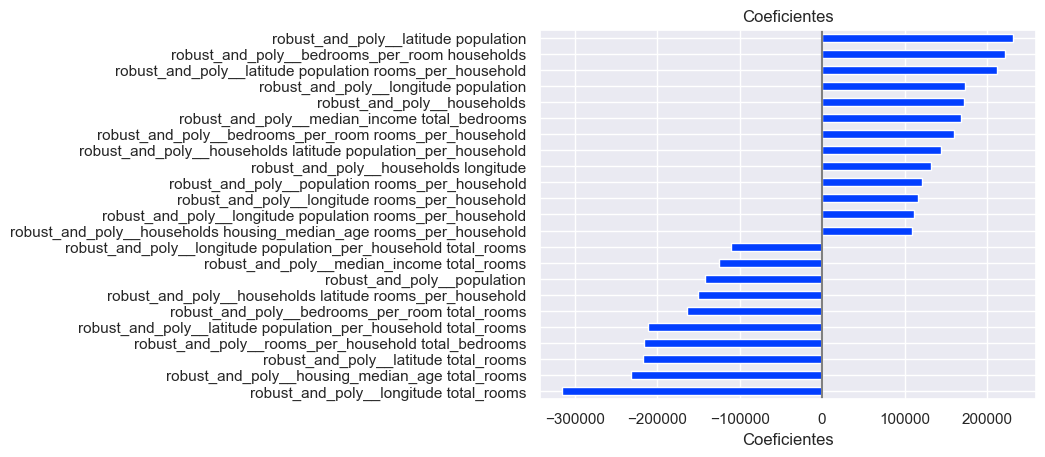

In [15]:
# Selecionando os mais relevantes
plot_coeficientes(coefs[~coefs['coeficiente'].between(-100_000, 100_000)])

- Os maiores coeficientes considerando seus valores absolutos, no geral são as features combinadas que é uma característica do PolynomialFeatures, porém levando em consideração que o que determina os valores dos coeficientes é uma característica matemática interna do modelo, fica difícil explicar a relação desses coeficientes com a variável alvo(median_house_value).

In [16]:
# Recriando o dicionário de regressores para a nova análise
regressors = {
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinearRegression': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
    'LinearRegression_target': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    },
    'LinearRegression_grid_search': {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    },
}

In [17]:
# Treinando e validando os modelos do dicionário de regressores. Transformando os resultados em um DF.
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **modelo_etapas)
    for nome_modelo, modelo_etapas in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.0,0.015464,-0.000081,-77516.042766,-96239.705692,0.015464
1,DummyRegressor,0.0,0.018391,-0.000146,-75787.787194,-95217.629397,0.018391
2,DummyRegressor,0.006121,0.007313,-0.001737,-76753.598961,-96253.253947,0.013434
3,DummyRegressor,0.006,0.006977,-0.000101,-76837.804811,-95983.885799,0.012977
4,DummyRegressor,0.0,0.015915,-0.000114,-76617.245449,-96182.764729,0.015915
5,LinearRegression,0.064027,0.032055,0.682162,-39855.690996,-54254.958188,0.096082
6,LinearRegression,0.083929,0.015763,0.66999,-40272.565467,-54695.230283,0.099691
7,LinearRegression,0.079834,0.016084,0.649247,-42178.05929,-56955.988706,0.095918
8,LinearRegression,0.072886,0.023138,0.669873,-40806.492497,-55146.318803,0.096023
9,LinearRegression,0.063495,0.016062,0.669023,-40788.496497,-55331.35106,0.079557


In [18]:
df_resultados.groupby('model').mean().sort_values(by='time_seconds')

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002424,0.012812,-0.000436,-76702.495836,-95975.447913,0.015236
LinearRegression,0.072834,0.02062,0.668059,-40780.26095,-55276.769408,0.093454
LinearRegression_target,0.079579,0.023861,0.678172,-38679.071225,-54424.024025,0.10344
LinearRegression_grid_search,1.140699,0.043775,0.7158,-35580.828504,-51141.144802,1.184473


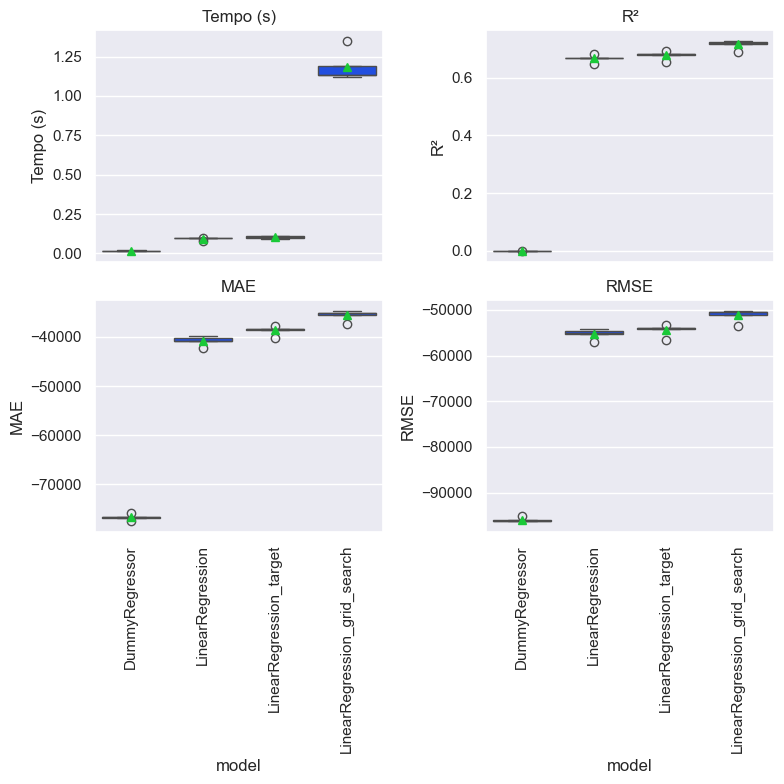

In [19]:
plot_comparar_metricas_modelos(df_resultados)

Naturalmente o tempo de execução for maior para o modelo com PolynomialFeatures, porém também obtivemos uma melhora nas métricas.

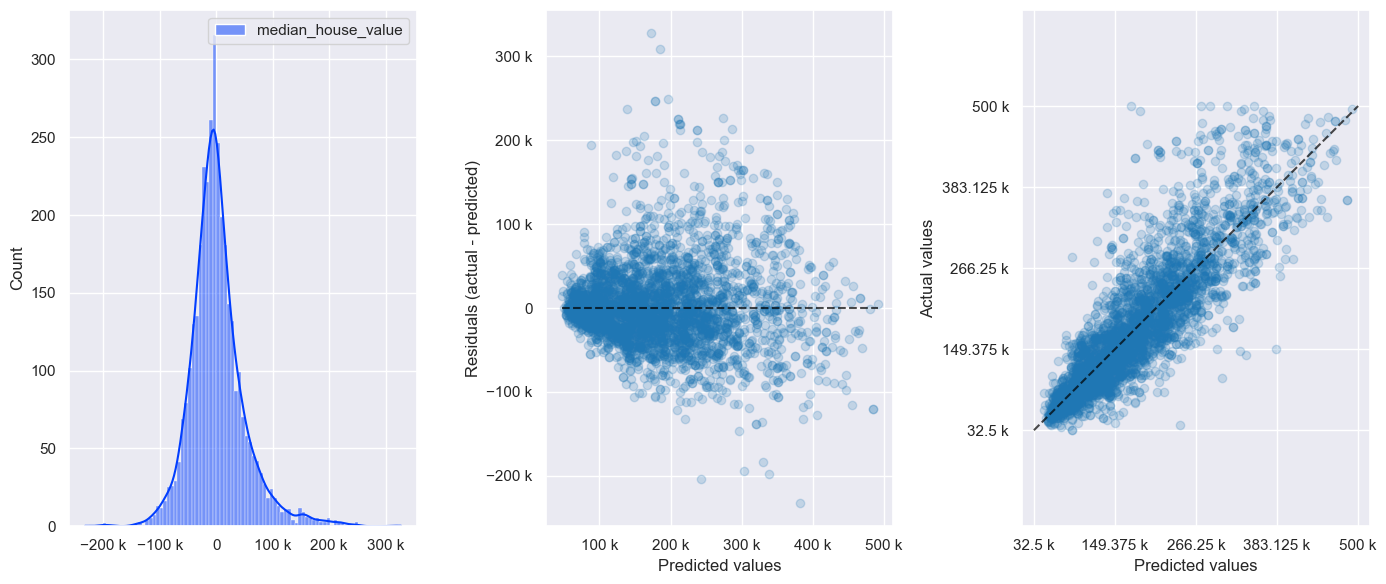

In [20]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.2, eng_formatter=True)

O modelo continua tendo dificuldades em prever o preços das casas que possuem valores mais altos.

### Conclusão
- As features polinomiais de fato melhoraram as métricas de interesse, isso resultou em uma penalidade em relação ao tempo de execução(mas, isso já é esperado, pelo aumento de features). Com o aumento exponencial de features, também ouve um aumento na dificuldade de interpretação dessas novas features polinomiais, quando comparado a análise anteior `04-fb-model_part_02.ipynb`; Anteriormente basicamente o que era importante para determinar o "median_house_value" era a **Renda** e a **Localização**, o que é bastante intuitivo e fácil de explicar para qualquer um que conhece sobre mercado imobiliário.